# **Imports**

Below are all the **modules** used in the **notebook**.

In [5]:
from IPython.display import clear_output as cls
!pip install scipy nibabel
cls()

In [132]:
# Common
import os 
import numpy as np
import tensorflow as tf

# Data 
from glob import glob
from tqdm import tqdm
import nibabel as nib
from scipy import ndimage

# Data Visualization
import matplotlib.pyplot as plt

# Model 
from keras.models import Sequential
from keras.layers import Layer, Conv3D, BatchNormalization, MaxPool3D, GlobalAveragePooling3D as GAP3D, Dense, Dropout, InputLayer

# Optimizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# **3D Scans Data Loading**

Before loading the data, we need to first understand the data, a detailed information is availabel in this [paper](https://arxiv.org/ftp/arxiv/papers/2005/2005.06465.pdf). As per the paper **CT-2, CT-3, and CT-4** are refered as **"Moderate", "Severe" and "Critical"**. So these are our **target values**.

In [16]:
# Path to the Root Directory
root_path = "/kaggle/input/mosmed-covid19-ct-scans/"

Let's have a look at the **class distribution**. That is the **total number of CT scans** available for **each class**.

In [21]:
# Define All Classes 
classes = ["CT-2", "CT-3", "CT-4"]

In [20]:
print(f"Total Number of Scans of {classes[0]} : {len(os.listdir(root_path + classes[0]))} Scans")
print(f"Total Number of Scans of {classes[1]} : {len(os.listdir(root_path + classes[1]))} Scans")
print(f"Total Number of Scans of {classes[2]} : {len(os.listdir(root_path + classes[2]))} Scans")

Total Number of Scans of CT-2 : 125 Scans
Total Number of Scans of CT-3 : 45 Scans
Total Number of Scans of CT-4 : 2 Scans


As you can notice at the **total number of scan** available for **CT-4** is **2**. So instead of using **CT-4** as a **different class**, we can **merge** these **scans** with the **CT-3**, or use the **CT-3 scans only as our classes**. So the **final classes are CT-2 and CT-3**.

In [22]:
# Permanent Class Names
class_names = classes[:2]

Although this is a **3-Dimensional data**, the **loading procedure** is **not much different**.

In [28]:
# Collect all CT Scan Paths
ct2_paths = glob(root_path+class_names[0] + "/*")
ct3_paths = glob(root_path+class_names[1] + "/*")

In [31]:
ct2_paths[:5]

['/kaggle/input/mosmed-covid19-ct-scans/CT-2/study_0994.nii',
 '/kaggle/input/mosmed-covid19-ct-scans/CT-2/study_0957.nii',
 '/kaggle/input/mosmed-covid19-ct-scans/CT-2/study_1047.nii',
 '/kaggle/input/mosmed-covid19-ct-scans/CT-2/study_0992.nii',
 '/kaggle/input/mosmed-covid19-ct-scans/CT-2/study_1032.nii']

These are the **data paths**, the next task is to **iterate through the paths** and **load them**. Due to **memeory constraints** we **won't be able to load data in large chunk**.

In [32]:
def load_nii(path):
    '''The function takes the path and loads the respective NII file.'''
    scan = nib.load(path)
    scan = scan.get_fdata()
    return scan

Let's test this function on a single data path.

In [33]:
scan = load_nii(ct2_paths[0])
print(f"Original Shape : {scan.shape}")

Original Shape : (512, 512, 40)


The **original shape** of the **data** is large as compared to the **amount of data we can process**. So we will resize the data as a chunk of **60 x 60 x 40**. Before doing that we need to do **2 more things**.

1. Data Normalization 
 * We will normalize the data between -1000 and 400. Because that's were the general information is stroed.
2. Maintaiin Orientation
 * In order to maintain the orientation, we will rotate all these scans at 90 degree.

In [71]:
def process_scan(scan, desired_dims=(60, 60, 30)):
    '''The function takes in the scan and apply all the preprocessing steps.'''
    
    # Define Normalize Range
    min, max = -1000, 400
    
    # Fix the vaues
    scan[scan < min] = min
    scan[scan > max] = max
    
    # Normalize Scan
    normalized_scan = (scan - min)/(max - min)
    normalized_scan = normalized_scan.astype('float32')
    
    # Resizing The Scan
    current_height, current_width, current_depth = normalized_scan.shape # (512, 512, 40)
    desired_height, desired_width, desired_depth = desired_dims
    
    # Get the Factors --> Based on Spline Interpolation 
    height_factor = desired_height/current_height
    width_factor = desired_width/current_width
    depth_factor = desired_depth/current_depth
    
    # Resized Scan --> Perform Cubic Spline Interpolation
    resized_scan = ndimage.zoom(normalized_scan, zoom=(height_factor, width_factor, depth_factor), order=3)
    
    # Rotate Scan
    rotated_scan = ndimage.rotate(resized_scan, angle=90, reshape=False)
    
    # Reshape data for Model Intake
    rotated_scan = tf.expand_dims(rotated_scan, axis=-1)
    
    # Return the final Scan
    return rotated_scan

More details about spline interpolation in this [video](https://www.youtube.com/watch?v=LaolbjAzZvg). Let's check the operation of this function.

In [73]:
processed_scan_org = process_scan(scan, desired_dims=(60, 60, 40)) # Original Depth Dimension
processed_scan_red = process_scan(scan, desired_dims=(60, 60, 30)) # Reduced Depth Dimension
print(f"Processed Scan : {processed_scan_org.shape}")

Processed Scan : (60, 60, 40, 1)


It will be **better to understand** these scans by **visualization**.

In [94]:
def show_scan_slices(scan, figsize=(25,8)):
    
    # We know that the scan it expanded. So let's squeeze it.
    slices = tf.squeeze(scan)
    
    # Plotting Configuratrtion
    n_rows, n_cols = slices.shape[-1]//10, 10 # This is based on our prior knowledge that we have 30 slices
    plt.figure(figsize=figsize)
    
    # Iterate through slices and plot it.
    for depth in range(slices.shape[-1]):
        slice = tf.expand_dims(slices[:,:,depth], axis=-1) # Converting from : 60 x 60 ==> 60 x 60 x 1
        
        # Plot this slice
        plt.subplot(n_rows, n_cols, depth+1)
        plt.imshow(slice, cmap='binary_r')
        plt.axis('off')
    
    # Show the final plot
    plt.show()

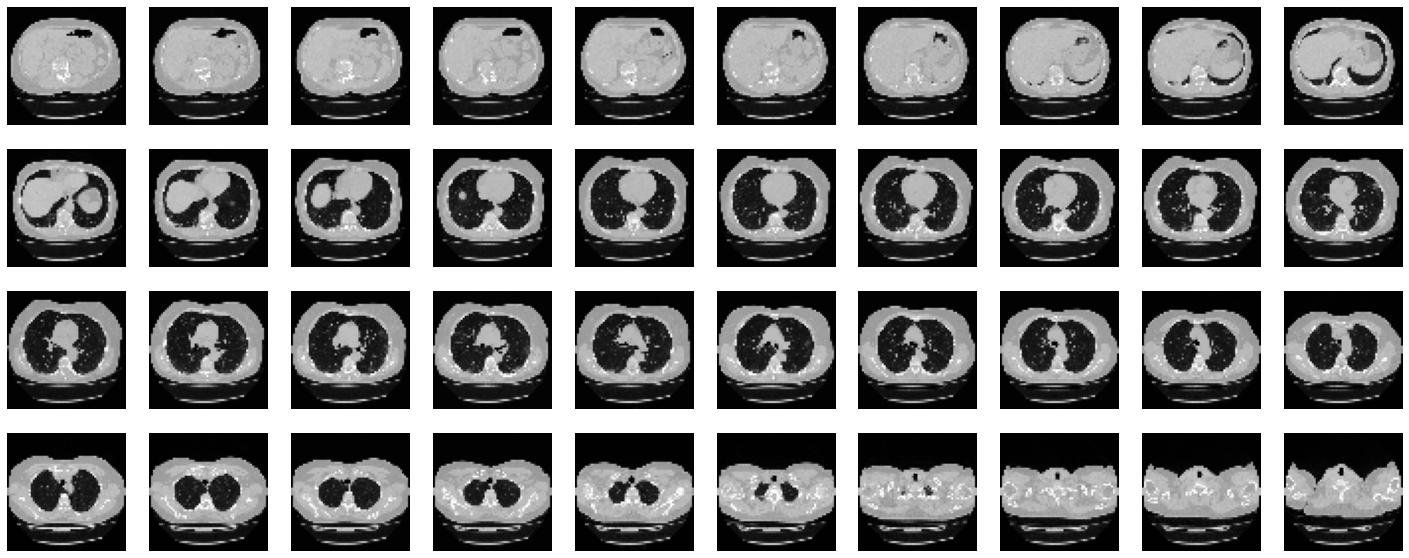

In [95]:
show_scan_slices(processed_scan_org, figsize=(25,10))

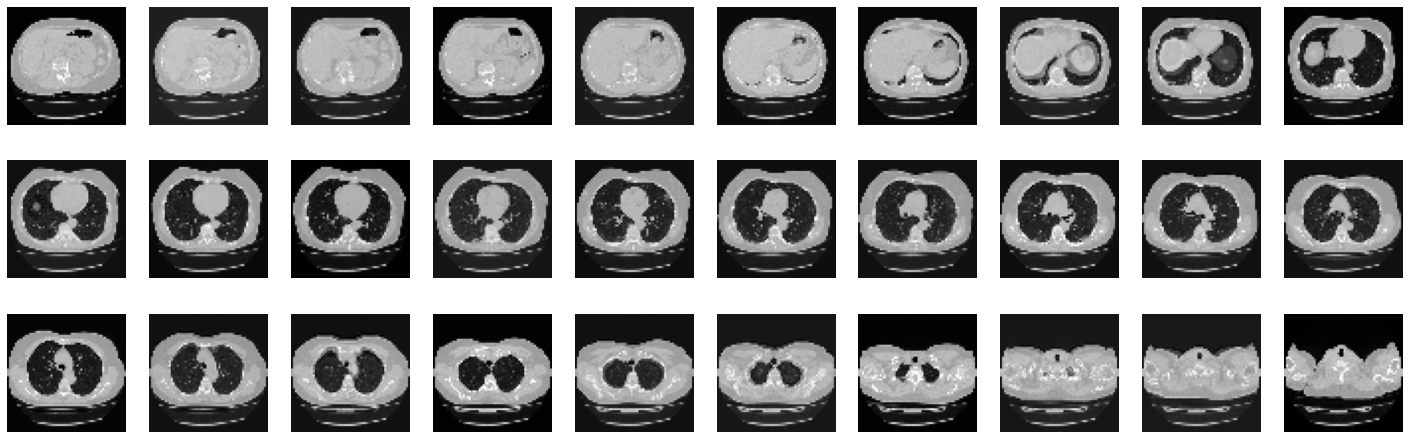

In [96]:
show_scan_slices(processed_scan_red, figsize=(25,8))

If you plot the **original scan slices** and look at the **depth dimension**, you will find that the **spline interpolation** is approximating that **40 depth dimension** to **30 depth dimension**. Because we have reduced the **spatial dimension** from **512 x 512 to 60 x 60** you can spot a **clear loss** in the **resolution**. OK, so now you can see how the **processing functions are working**, and the **final scan**. Let's **load the whole data**.

In [102]:
def load_data(paths, label=0):
    
    # Create space for the data
    scans = np.empty(shape=(len(paths), 60, 60, 30, 1), dtype='float32') # This is from our prior knowledge
    labels = np.empty(shape=(len(paths),), dtype='int32')
    
    # Iterate through the paths and load the scan
    for i, path in tqdm(enumerate(paths), desc="Loading"):
        
        # load the Scan
        scan = load_nii(path)
        
        # Process Scan
        scan = process_scan(scan, desired_dims=(60,60,30))
        
        # Append Data
        scans[i] = scan
        labels[i] = label
    
    # Return Data 
    return scans, labels

In [113]:
# Load Data
ct2_scans, ct2_labels = load_data(ct2_paths)
ct3_scans, ct3_labels = load_data(ct3_paths, label=1)

Loading: 125it [01:43,  1.20it/s]
Loading: 45it [00:36,  1.22it/s]


In [114]:
# Collect Data 
all_scans = np.concatenate([ct2_scans, ct3_scans], axis=0)
all_labels = np.concatenate([ct2_labels, ct3_labels], axis=0)

# Problem 
print(f"Labels : {all_labels}")

Labels : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


As you can see, all these **labels are in a correct order**. And this **format** will **not be perfect** for the **model** as it will **not generalize the model**.

In [128]:
SEED = 42
np.random.shuffle(all_scans)
np.random.shuffle(all_labels)

In [140]:
all_labels

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0], dtype=int32)

Final check,

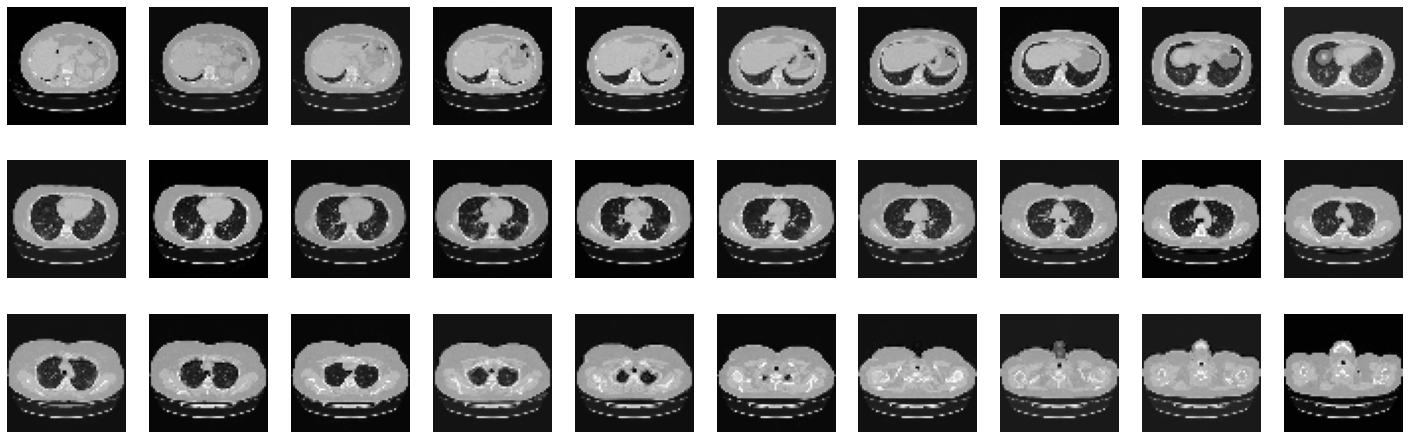

In [129]:
show_scan_slices(all_scans[45])

# **3D Scan Model**

The model we are going to create in this notebook is inspired by this [paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjr_8jPw438AhVY5nMBHdIvDOoQFnoECBUQAQ&url=https%3A%2F%2Farxiv.org%2Fabs%2F2007.13224&usg=AOvVaw3bg9FAcA0akVu77ESfKEyJ). As we'll have to replicate **layers again and again**. Let's **encode all layers into a single layer**.

In [116]:
class ConvBlock(Layer):
    
    def __init__(self, filters, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        
        self.filters = filters
        
        self.net = Sequential([
            Conv3D(filters, kernel_size=3, padding='same', strides=1, activation='relu', kernel_initializer='he_normal'),
            MaxPool3D(pool_size=2),
            BatchNormalization()
        ])
        
    def call(self,X):
        return self.net(X)
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters
        }

Finally, we have our **output module**, which will make the **final prediction**. Let's **create a layer for that module too**.

In [118]:
class OutputBlock(Layer):
    
    def __init__(self, n_classes=1, **kwargs): # Maybe the data in which you operate has more number of classes
        super(OutputBlock, self).__init__(**kwargs)
        
        self.n_classes = n_classes
        
        self.net = Sequential([
            GAP3D(),
            Dropout(0.2),
            Dense(n_classes, activation='sigmoid')
        ])
    
    def call(self, X):
        return self.net(X)
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "n_classes":self.n_classes
        }

Model architecture,

In [138]:
# Give the model a name
Model_name ="3D_Scans_Model"
Model_size = (60,60,40,1)

# Model Architecture
model = Sequential([
    InputLayer(Model_size, name="Input"),
    ConvBlock(16, name="Block_1"),
    ConvBlock(32, name="Block_2"),
    Dropout(0.2, name="Drop_2"),
    ConvBlock(64, name="Block_3"),
    OutputBlock(name="Output")
], name=Model_name)

# Model Summary
model.summary()

Model: "3D_Scans_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Block_1 (ConvBlock)          (None, 30, 30, 20, 16)    512       
_________________________________________________________________
Block_2 (ConvBlock)          (None, 15, 15, 10, 32)    13984     
_________________________________________________________________
Drop_2 (Dropout)             (None, 15, 15, 10, 32)    0         
_________________________________________________________________
Block_3 (ConvBlock)          (None, 7, 7, 5, 64)       55616     
_________________________________________________________________
Output (OutputBlock)         (None, 1)                 65        
Total params: 70,177
Trainable params: 69,953
Non-trainable params: 224
_________________________________________________________________


# **Model Training**

In [139]:
# Compile Model 
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

# Define Callbacks
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint(Model_name + ".h5", save_best_only=True)
]

# Train Model
model.fit(all_scans, all_labels, validation_split=0.1, epochs=20, batch_size=8, callbacks=callbacks)

Epoch 1/20
20/20 [==============================] - 6s 252ms/step - loss: 0.6906 - accuracy: 0.5686 - val_loss: 0.8483 - val_accuracy: 0.3529
Epoch 2/20
20/20 [==============================] - 5s 243ms/step - loss: 0.6134 - accuracy: 0.6667 - val_loss: 0.8923 - val_accuracy: 0.3529
Epoch 3/20
20/20 [==============================] - 5s 262ms/step - loss: 0.5821 - accuracy: 0.7582 - val_loss: 0.9243 - val_accuracy: 0.6471
Epoch 4/20
20/20 [==============================] - 6s 302ms/step - loss: 0.5709 - accuracy: 0.7451 - val_loss: 0.7088 - val_accuracy: 0.6471
Epoch 5/20
20/20 [==============================] - 5s 261ms/step - loss: 0.5395 - accuracy: 0.7712 - val_loss: 0.8338 - val_accuracy: 0.6471
Epoch 6/20
20/20 [==============================] - 5s 254ms/step - loss: 0.5171 - accuracy: 0.7647 - val_loss: 0.7384 - val_accuracy: 0.6471
Epoch 7/20
20/20 [==============================] - 5s 238ms/step - loss: 0.5042 - accuracy: 0.7778 - val_loss: 1.2156 - val_accuracy: 0.6471


I **haven't performed any hypertuning** on this **model** because the **training data is extremely less(in terms of number)**. That's why it is **not possible** to actually tune the **model**. But this gives you a brief introduction to **3D scan data set** and **3D CNN models**. That's **all from my side**. Let me know your **solutions in the comments**. 

---
**DeepNets**